In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute
X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))
print(X_motion.shape)
print(Y_motion.shape)

(1558, 20)
(1558, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where RL swings
idxs = np.where(X_motion[:, -1] == 1)[0]
X_motion_RL_swinging = X_motion[idxs]
Y_motion_RL_swinging = Y_motion[idxs]

## Predict RL foot -> x

In [8]:
X_motion_RL_swinging[0, :]

array([ 0.        ,  0.        ,  0.        ,  0.23939471,  0.12513311,
       -0.38203356,  0.24643272, -0.13321123, -0.3814055 , -0.25672796,
        0.12573184, -0.38702354, -0.26360762, -0.12588781, -0.38105795,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ])

In [9]:
X_motion_RL_swinging[0, :]

array([ 0.        ,  0.        ,  0.        ,  0.23939471,  0.12513311,
       -0.38203356,  0.24643272, -0.13321123, -0.3814055 , -0.25672796,
        0.12573184, -0.38702354, -0.26360762, -0.12588781, -0.38105795,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ])

### Linear Regression

In [10]:
# Input
X = np.hstack((X_motion_RL_swinging[:, :3], # Previous motion command
               X_motion_RL_swinging[:, -5:-2], # Current motion command
               X_motion_RL_swinging[:, 3:5], # FL (x,y) position
               X_motion_RL_swinging[:, 6:8], # FR (x,y) position
               X_motion_RL_swinging[:, 9:11], # RL (x,y) position
               X_motion_RL_swinging[:, 12:14])) # RR (x, y) position

# Target
Y = np.array([Y_motion_RL_swinging[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rl_relative_swinging_x = LinearRegression()

# Fit the model
model_rl_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_rl_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9931796443371026
RMSE:  0.01125773327739739
The lowest error is:  7.853018475501017e-07
The highest error is:  0.035977556390737075
The avg. error is:  0.008346170247520785


In [11]:
model_rl_relative_swinging_x.coef_

array([[ 1.81035817e-01, -7.77156117e-16, -2.22044605e-16,
         3.65433886e-02,  1.38777878e-17, -4.44089210e-16,
         7.88566984e-01, -1.78873191e+00, -4.77300888e-01,
         9.45425111e-01, -1.65244003e+00,  3.31605078e-01,
        -2.17096235e-01,  1.04456496e+00]])

In [12]:
model_rl_relative_swinging_x.intercept_

array([-0.11744163])

Text(0, 0.5, 'Predictions')

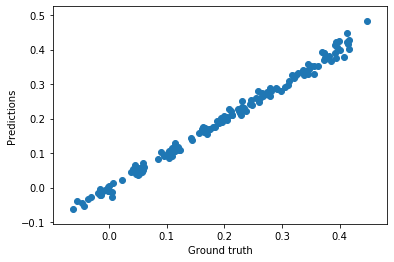

In [13]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [14]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

### Predict RL foot -> y

In [15]:
# Input
X = np.hstack((X_motion_RL_swinging[:, :3], # Previous motion command
               X_motion_RL_swinging[:, -5:-2], # Current motion command
               X_motion_RL_swinging[:, 3:5], # FL (x,y) position
               X_motion_RL_swinging[:, 6:8], # FR (x,y) position
               X_motion_RL_swinging[:, 9:11], # RL (x,y) position
               X_motion_RL_swinging[:, 12:14])) # RR (x, y) position

# Target
Y = np.array([Y_motion_RL_swinging[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rl_relative_swinging_y = LinearRegression()

# Fit the model
model_rl_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_rl_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.5519762325995614
RMSE:  0.007026685336127867
The lowest error is:  1.5669647008463572e-05
The highest error is:  0.02427206633452958
The avg. error is:  0.005457900564344073


In [16]:
model_rl_relative_swinging_y.coef_

array([[-3.00089106e-02, -3.46944695e-18, -3.98986399e-16,
         2.18679815e-02,  1.11022302e-16,  0.00000000e+00,
         1.29802972e-01,  3.24624063e-01, -1.46975517e-01,
        -8.02841269e-01,  2.18336898e-01, -1.36810493e+00,
         3.23640331e-02,  3.12807929e-01]])

In [17]:
model_rl_relative_swinging_y.intercept_

array([0.13049389])

Text(0, 0.5, 'Predictions')

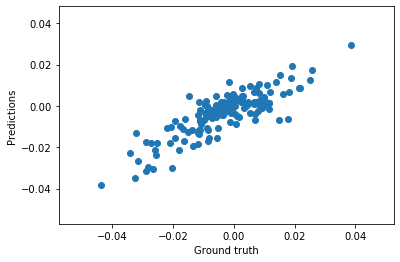

In [18]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [19]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')